# Расчёт геометрии сопла

Согласно методичке нам следует описать код, отвечающий за расчёт следующих параметров сопла.

Диаметр выходного сечения:

$$
d_\mathrm{в} = d_* \sqrt{\nu_\mathrm{в}}.
$$

Координата выходного сечения сопла:

$$
x_* = \frac{D_\mathrm{к} - d_*}{2 \tan \alpha}.
$$

Координата выходного сечения:

$$
x_\mathrm{в} = x_* + \frac{d_\mathrm{в} - d_*}{2 \tan \beta}.
$$

Также необходимо определить формулу для расчёта диаметра сечения сопла в зависимости от его $x$-координаты:

$$
d(x) = \begin{cases}
    D_\mathrm{к} - (D_\mathrm{к} - d_*) \cfrac{x}{x_*}, &x \le x_*, \\
    d_* + (d_\mathrm{в} - d_*) \cfrac{x - x_*}{x_\mathrm{в} - x_*}, & x > x_*.
\end{cases}
$$

Теперь создадим класс сопла, в котором будем хранить его геометрические параметры и определим _метод класса_ `diameter_at(self, x)`, ответственный за расчёт диаметра сечения с любой координатой $x$.

## Класс сопла

Для начала подключим NumPy.
Его мы будем использовать в методе `diameter_at` для того, чтобы мочь считать $d(x)$ не только для одного значения, а для массивов значений координаты $x$.

```{note}
Почитайте об объектно-ориентированном программировании в Python и о его классах.
Основы можно узнать [здесь](https://devpractice.ru/python-lesson-14-classes-and-objects/?ysclid=ltijlugswo129534363).
```

In [1]:
import numpy as np

Теперь опишем класс `Nozzle` (сопло):

In [2]:
# Понадобится небольшая математика
from math import sqrt, tan, pi

class Nozzle:
    # __init__ - это конструктор экземпляра класса,
    # т.е. тот код, который выполняется при создании объекта класса
    def __init__(self,
                 d_chamber: float,
                 d_critic: float,
                 area_ratio: float,
                 confuser_angle: float,
                 diffuser_angle: float):
        self.d_chamber = d_chamber
        self.d_critic = d_critic
        self.area_ratio = area_ratio
        self.alpha = confuser_angle
        self.beta = diffuser_angle
        # Расчётные параметры вынесем в отдельный приватный метод
        self._init_geometry()
    
    # Данный метод является приватным - его имя начинается с _.
    # Вне класса этот метод напрямую недоступен.
    def _init_geometry(self):
        # Выполняем расчёт по формулам.
        self.d_out = self.d_critic * sqrt(self.area_ratio)
        self.x_critic = 0.5*(self.d_chamber - self.d_critic) / tan(self.alpha)
        self.x_out = self.x_critic + 0.5*(self.d_out - self.d_critic) / tan(self.beta)
        self.area_critic = 0.25 * pi * self.d_critic**2
    
    # Метод для расчёта d(x)
    def diameter_at(self, x):
        x = np.asarray(x)
        d = np.empty_like(x, dtype=np.float64)
        confuser = x < self.x_critic
        d[confuser] = \
            self.d_chamber \
            - (self.d_chamber - self.d_critic) * x[confuser]/self.x_critic
        diffuser = x >= self.x_critic
        d[diffuser] = \
            self.d_critic \
            + (self.d_out - self.d_critic) \
            * (x[diffuser] - self.x_critic)/(self.x_out - self.x_critic)
        return d

В методах `__init__` и `_init_geometry` нет ничего особенного (если вы в курсе классов в Python).
Подробнее рассмотрим метод `diameter_at(self, x)`, в котором задействуется NumPy.

1. Преобразовали входной аргумент `x` в переменную NumPy (не важно, чем был `x` на входе - числом или массивом):
   
   ```{code} python
   x = np.asarray(x)
   ```
2. Создали пустой массив вещественных чисел с таким же (like) размером, что и `x`:
   
   ```{code} python
   d = np.empty_like(x, dtype=np.float64)
   ```
3. Определили индексы массивов, при которых выполняется условие $x \le x_*$ (конфузор сопла):
   
   ```{code} python
   confuser = x < self.x_critic
   ```
4. Сформировали массив значений диаметров конфузора:
   
   ```{code} python
   d[confuser] = ...
   ```
5. Определили индексы массивов, при которых выполняется условие $x > x_*$ (диффузор сопла):
   
   ```{code} python
   diffuser = x >= self.x_critic
   ```
6. Посчитали диаметры сечений диффузора:
   
   ```{code} python
   d[diffuser] = ...
   ```
7. Вернули сформированный массив диаметров всех сечений сопла:
   
   ```{code} python
   return d
   ```

```{note}
Обратный слэш `\` в Python используется для разбивки длинной строки на несколько строк.
```

Вот как теперь мы можем создать экземпляр сопла:

In [3]:
from math import radians

noz = Nozzle(
    d_chamber=3.5*0.6,  # м
    d_critic=0.6,       # м
    area_ratio=6,
    confuser_angle=radians(45),
    diffuser_angle=radians(9)
)
# При этом выполнился весь код в __init__

Теперь можно обращаться к всяким параметрам сопла, например:

In [4]:
# К полям экземпляра, которые мы назначили при его создании
print("Диаметр критического сечения, м:", noz.d_critic)
print("Угол конуса диффузора, рад:", noz.beta)
# а также к полям, которые были рассчитаны, к примеру,
print("Координата выходного сечения сопла, м:", noz.x_out)

Диаметр критического сечения, м: 0.6
Угол конуса диффузора, рад: 0.15707963267948966
Координата выходного сечения сопла, м: 3.4955154177009686


На самом деле мы уже можем показать геометрию сопла.
Переходим к визуализации с помощью Matplotlib.

## Визуализируем профиль сопла

Подключим библиотеку Matplotlib.

```{note}
О том, как создавать визуализации с помощью Matplotlib, вы можете узнать из
[этого веб-пособия](https://unexpectedcoder.github.io/sm6-py-cookbook/intro.html)
по основам Python.
```

In [5]:
import matplotlib.pyplot as plt

Посчитаем диаметры сечений сопла при $x \in [0; x_\mathrm{в}]$, разбив этот отрезок на 200 точек:

In [6]:
x = np.linspace(0, noz.x_out, 200)
d = noz.diameter_at(x)

Только и всего!
Теперь можем строить график диаметра $d(x)$, радиуса $r(x) = d(x) / 2$ и площади поперечного сечения $S(x) = \pi d(x)^2 / 4$ сопла.

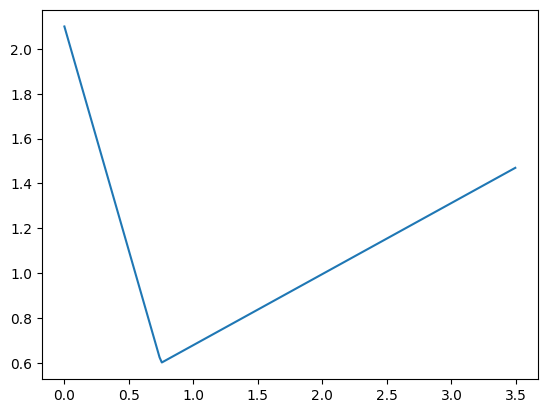

In [7]:
fig, ax = plt.subplots()
ax.plot(x, d);

Графику по умолчанию многого не достаёт (подписей осей, сетки и т.п.):

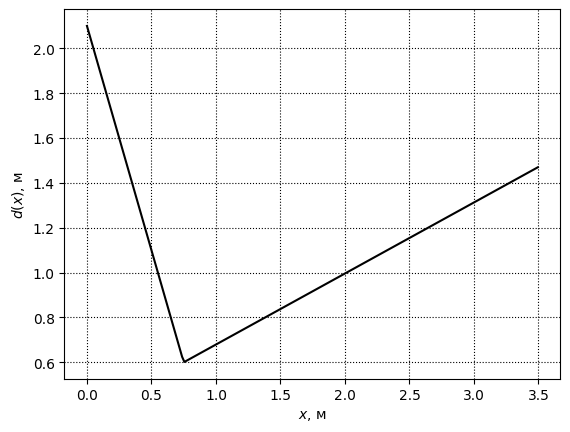

In [8]:
fig, ax = plt.subplots()
ax.plot(x, d, c="k")    # "k" == "key" - чёрный цвет линии plot
ax.set(
    xlabel="$x$, м",    # подпись оси x
    ylabel="$d(x)$, м"  # подпись оси y
)
# Настройка сетки
ax.grid(True, ls=":", c="k");

Уже поинтереснее, но можно и лучше (со стилевым контекстом, например):

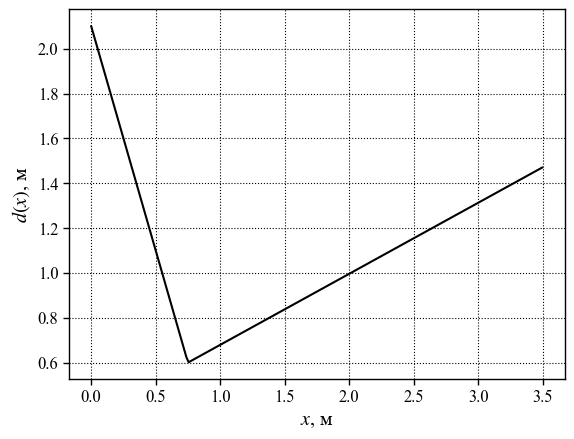

In [9]:
# Подключаем стилевой контекст
with plt.style.context("../sciart.mplstyle"):
    fig, ax = plt.subplots()
    ax.plot(x, d, c="k")
    ax.set(xlabel="$x$, м", ylabel="$d(x)$, м")
    ax.grid(True, ls=":", c="k")
    plt.show()

Радиус $r(x)$:

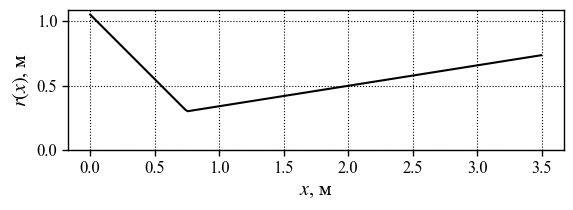

In [10]:
with plt.style.context("../sciart.mplstyle"):
    fig, ax = plt.subplots()
    ax.plot(x, d/2, c="k")
    ax.set(
        xlabel="$x$, м",
        ylabel="$r(x)$, м",
        aspect="equal",     # одинаковый масштаб по осям
        ylim=0              # минимальное значение на оси y
    )
    ax.grid(True, ls=":", c="k")
    plt.show()

Вот это уже неискажённая масштабом осей геометрия профиля сопла.

График площади сечений $S(x)$:

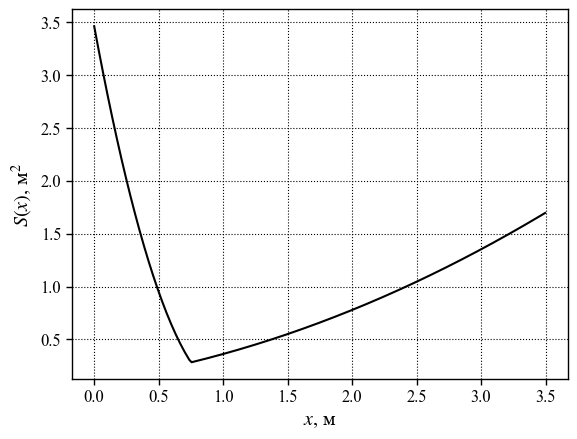

In [11]:
with plt.style.context("../sciart.mplstyle"):
    fig, ax = plt.subplots()
    ax.plot(x, 0.25 * pi * d**2, c="k")
    ax.set(xlabel="$x$, м", ylabel="$S(x)$, м$^2$")
    ax.grid(True, ls=":", c="k")
    plt.show()

Сохраним последний график в графический файл с именем `S.png` с 300 точками на дюйм (dpi):

```{code} python
fig.savefig("S.png", dpi=300)
```

В результате вы получите картинку PNG с отличным разрешением, которую с лёгкостью сможете вставить в любой текстовый документ.

```{important}
Стоит сохранять графики **до** их отображения методом `plt.show()`, чтобы не потерять их данные и не получить чушь в результате (наложение линий, цветов и т.д.).
```

Визуализацию сопла можно свести в отдельные функции:

In [15]:
def plot_nozzle_profile(x, noz: Nozzle):
    d = noz.diameter_at(x)
    fig, ax = plt.subplots(num="r")
    ax.plot(x, d/2, c="k")
    ax.set(
        xlabel="$x$, м",
        ylabel="$r(x)$, м",
        aspect="equal",
        ylim=0
    )
    ax.grid(True, ls=":", c="k")
    # Здесь же можно организовать и сохранение графиков
    return fig, ax

def plot_nozzle_S(x, noz: Nozzle):
    d = noz.diameter_at(x)
    fig, ax = plt.subplots(num="S")
    ax.plot(x, 0.25 * pi * d**2, c="k")
    ax.set(xlabel="$x$, м", ylabel="$S(x)$, м$^2$")
    ax.grid(True, ls=":", c="k")
    # Здесь же можно организовать и сохранение графиков
    return fig, ax

Тогда построение геометрии любого сопла `noz` сведётся к вызову этой функции:

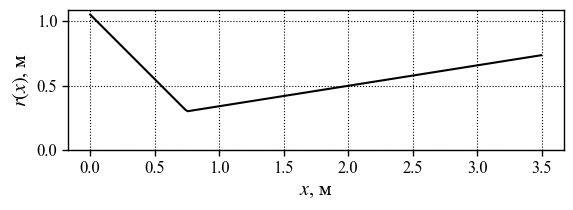

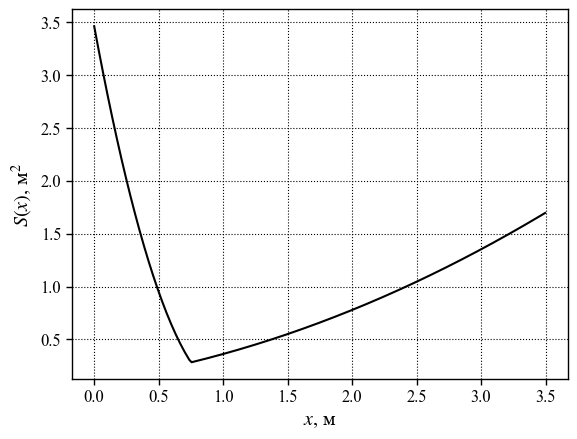

In [16]:
with plt.style.context("../sciart.mplstyle"):
    plot_nozzle_profile(x, noz)
    plot_nozzle_S(x, noz)
    plt.show()

С исходными данными и геометрией расправились.
Настало время газовой динамики!